---
# [aCompCor](https://linescanning.readthedocs.io/en/latest/classes/preproc.html#linescanning.preproc.aCompCor) for line-scanning

This notebook illustrates how to anatomical component correction (aCompCor) on line-scanning data. Though this may seem trivial on regular whole-brain fMRI data, the effect of aCompCor on line-scanning data is quite pronounced and therefore worthy of its own example notebook. We'll then also perform a quick analysis, and you can compare the results with the [nideconv](https://linescanning.readthedocs.io/en/latest/examples/nideconv.html) example.

In [9]:
# imports
from linescanning import dataset, plotting, utils, fitting
import warnings
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
import seaborn as sns

warnings.simplefilter('ignore')
project_dir     = "/mnt/d/FSL/shared/spinoza/projects"
base_dir        = opj(project_dir, 'hemifield')
deriv_dir       = opj(base_dir, 'derivatives')

plot_vox = 359
plot_xkcd = True

For aCompCor, we need some preparation steps before we can load everything in. We need the following:

- **A registration matrix mapping `ses-1` to the line-scanning session (e.g., `ses-3`)**; this one is generally obtained during the planning of the line with `spinoza_lineplanning`, but can be tailored to be closer to the first anatomical slice. For instance, we often acquire `multi-slice` images inbetween runs. Given that these images are often closer the line-scanning run, you can use `call_ses1_to_motion1` to create a matrix mapping `ses-1` to the first anatomical slice. 
- **Transformations mapping run-to-run**; the matrix above deals with session-to-session registration, but not motion inbetween runs. We can not see *every* bit of motion due to the 2D-nature of the data, but we can do our best. To get these registration matrices I use `ITK-Snap`. We'll define `run-1` as *moving* run, and the subsequent runs as *reference* runs. This means we need to open the *reference* images as `main` image in ITK-Snap, and the run-1 slice (*moving*) as overlay. Press `Tools` > `Registration` > `Manual` and align the slices to the best of your abilities. Then save the matrix by pressing the `save` icon on the bottom left as: `from-run1_to-run<run_ID>.txt` in the `anat`-folder of your line-scanning session

Now we have the ingredients to do aCompCor. For each run, the segmentations of `ses-1` will be transformed to the particular run using the 2 matrices provided (providing only 1 will lead to inaccurate alignment). We then perform PCA on the WM/CSF voxel timecourses. To eliminate the possibility of filtering out task-related frequencies, we high-pass the resulting components, before regressing them out. This is all done for you within the `linescanning.Dataset`-class.

In [2]:
# Load data
sub         = '003'
ses         = 3
task        = "task-SR"
runs        = [3,4,6]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
anat_dir    = opj(os.path.dirname(func_dir), 'anat')
ribbon      = (356,363)

run_files   = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir)
func_file   = utils.get_file_from_substring("bold.mat", run_files)
exp_file    = utils.get_file_from_substring("events.tsv", run_files)
anat_slices = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", "acq-1slice", ".nii.gz"], anat_dir)
ref_slices  = utils.match_lists_on(func_file, anat_slices, matcher='run')
ref_slices

['/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_acq-1slice_run-3_T1w.nii.gz',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_acq-1slice_run-4_T1w.nii.gz',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_acq-1slice_run-6_T1w.nii.gz']

Now we insert everything again in `dataset` as before, but now you'll see it outputs plots regarding the effect of aCompCor on the data

DATASET

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat
 Filtering strategy: 'hp'
 Standardization strategy: 'psc'
 Cutting 50 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Source dir: /mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-003/ses-1
 Target session: ses-3
 Foldover: FH
 Ref slice: /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_acq-1slice_run-3_T1w.nii.gz
 Trafo's: ['/mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/pycortex/sub-003/transforms/sub-003_from-ses1_to-ses3_rec-motion1_desc-genaff.mat', '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/anat/from-run2_to-run3.txt']
 Found 25 voxel for nuisance regression; (indices<300 are ignored due to distance from coil)
 We're good to go!
 Using 5 components for aCompCor (WM/CSF separately)
 Found 1 component(s) in 'csf'-voxels with total explained v

onset
subject run event_type                   
003     3   2.014613132977678   24.363776
            3.5652478065289     35.213706
            2.13914868391734    39.913720
            3.5652478065289     47.413652
            2.014613132977678   53.213640
...                                   ...
        6   1.140879298089248  373.028252
            1.853928859395028  378.111696
            1.140879298089248  382.953138
            2.13914868391734   387.653167
            2.014613132977678  394.244731

[150 rows x 1 columns]

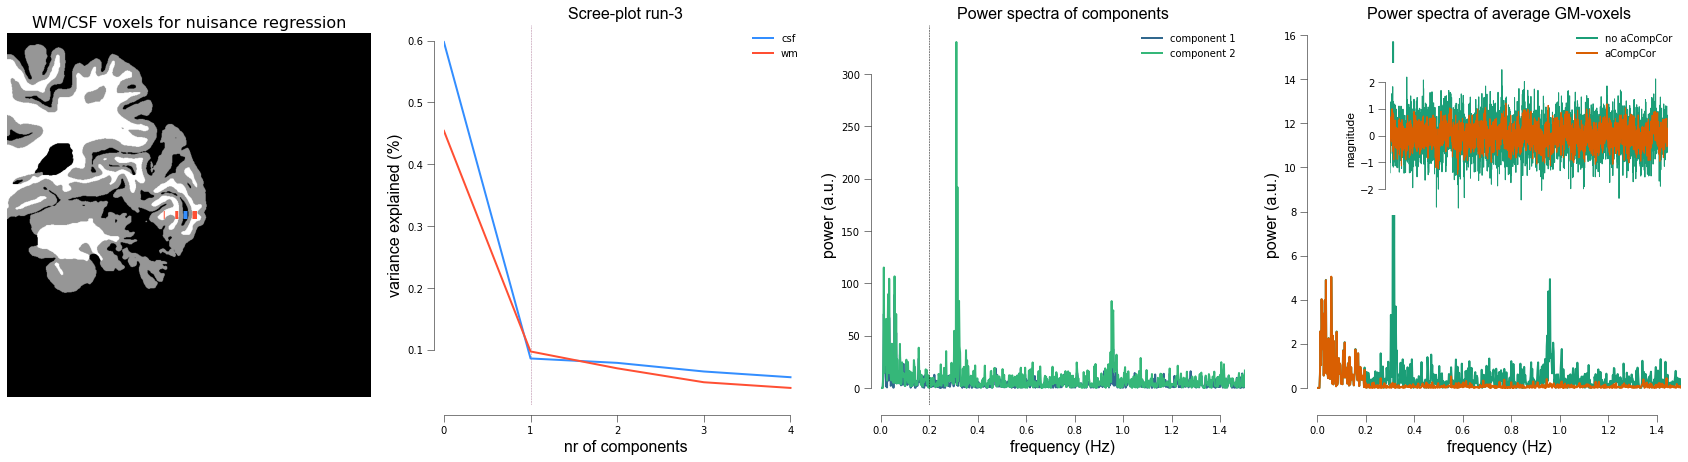

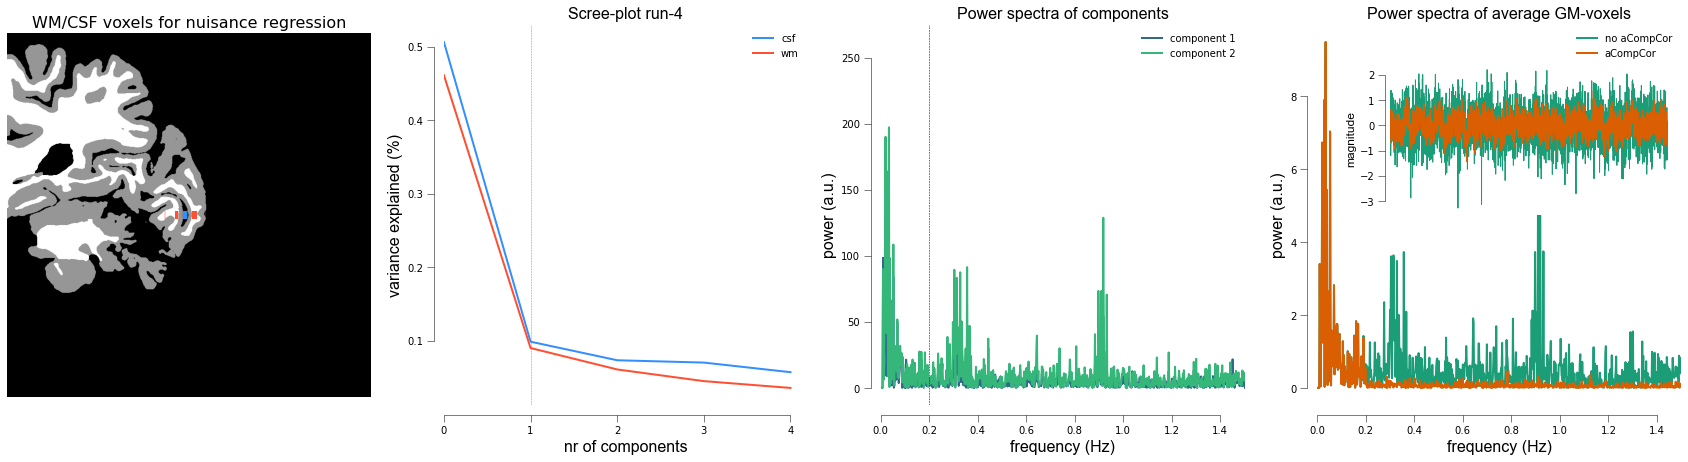

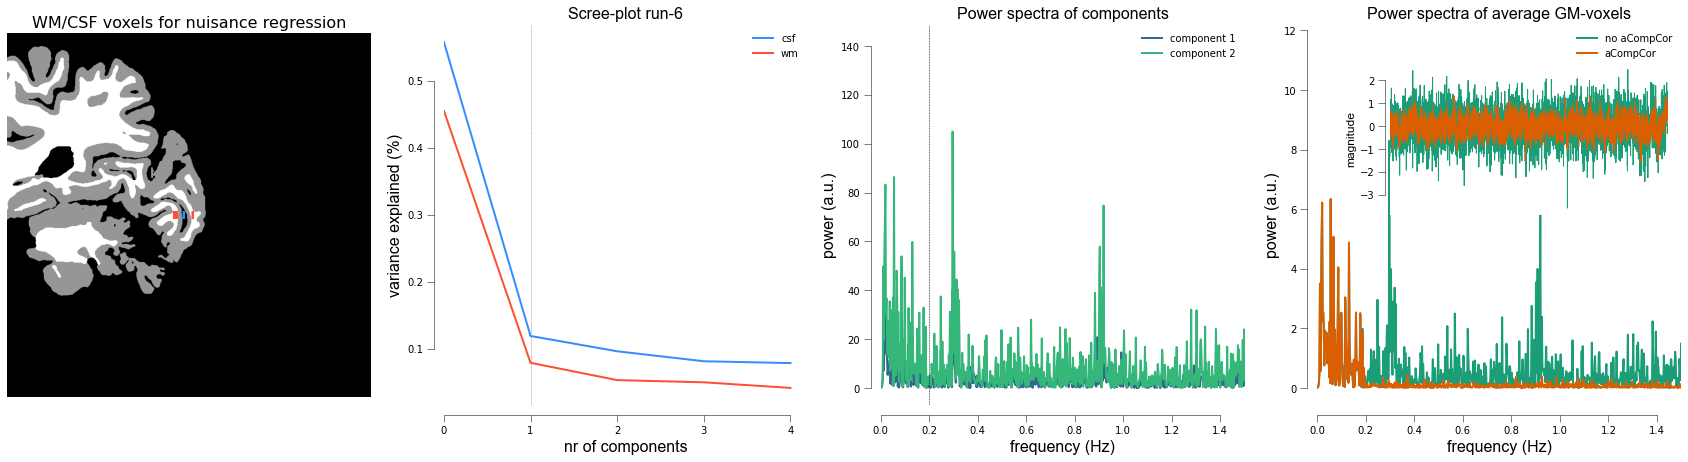

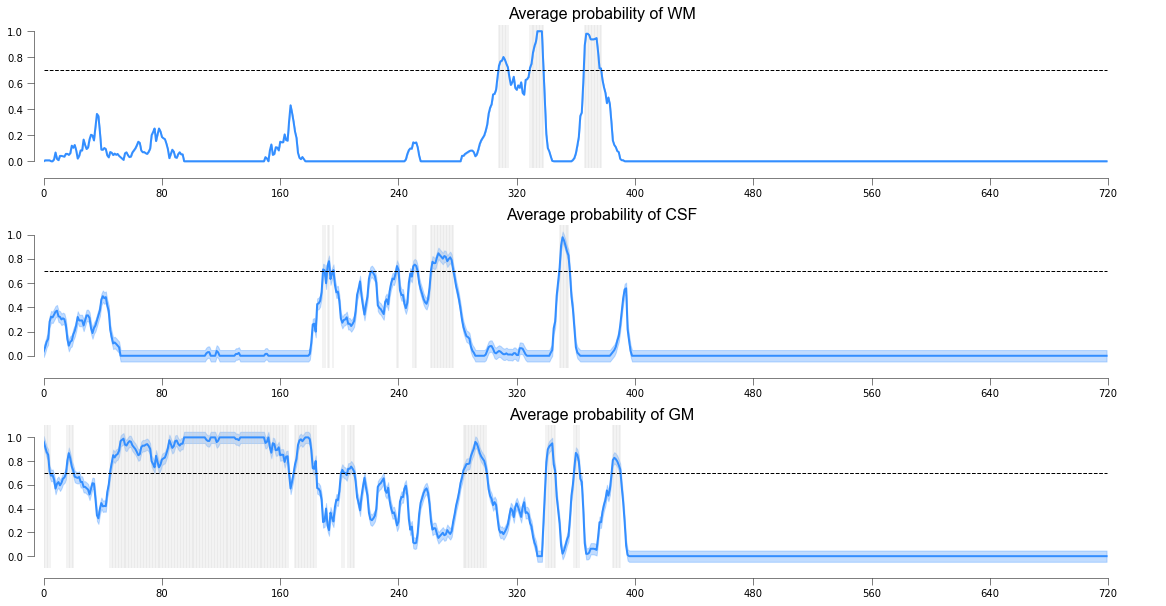

In [4]:
window = 19
order = 3

# mind you, the segmentations live in ses-1 space, NOT FREESURFER!
ses_to_motion = utils.get_file_from_substring(f"ses{ses}_rec-motion1", opj(deriv_dir, 'pycortex', f"sub-{sub}", 'transforms'))
run2run = utils.get_file_from_substring(['.txt'], anat_dir)

## OLD COMMAND
# data_obj = dataset.Dataset(func_file,
#                            deleted_first_timepoints=50, 
#                            deleted_last_timepoints=50,
#                            window_size=window, # needs to be odd
#                            high_pass=True,
#                            tsv_file=exp_file,
#                            poly_order=order,
#                            use_bids=True,
#                            verbose=True)

## NEW COMMAND WITH ACOMPCOR
data_obj = dataset.Dataset(func_file,
                           tsv_file=exp_file,
                           deleted_first_timepoints=50, 
                           deleted_last_timepoints=50,
                           use_bids=True,
                           verbose=True,
                           acompcor=True,
                           ref_slice=ref_slices,
                           ses1_2_ls=ses_to_motion,
                           run_2_run=run2run,
                           n_pca=5,
                           save_as=opj(anat_dir, f"sub-{sub}_ses-{ses}"),
                           standardization="psc")

df_func     = data_obj.fetch_fmri()
df_onsets   = data_obj.fetch_onsets()
df_onsets                           

For each run, the following is plotted:

- The WM (red) and CSF (blue) voxels used for PCA
- The scree plot of WM/CSF
- The power spectra of the selected components
- The power spectra of a real voxel timecourse before (green) and after (orange) aCompCor

You should be able to see that breathing-related frequencies (~0.25-0.3Hz) and cardiac frequencies (~1Hz) are largely removed. Now we're back with a dataframe that we can use with `NideconvFitter` as [before](https://linescanning.readthedocs.io/en/latest/examples/nideconv.html)

In [5]:
df_ribbon = utils.select_from_df(df_func, expression='ribbon', indices=ribbon)
df_ribbon

vox 356   vox 357   vox 358   vox 359   vox 360  \
subject run t                                                           
003     3   0.000    1.487041  1.795793  1.185977 -2.545929 -3.159982   
            0.105   -0.252366 -1.736116 -0.544530  0.305700  0.879002   
            0.210    0.041437  1.456225  2.473557  0.531971 -2.779514   
            0.315    0.367785 -0.361657  1.363826 -2.400070  0.726354   
            0.420    2.386761  3.056121  0.591087  2.823544 -0.733584   
...                       ...       ...       ...       ...       ...   
        6   450.975 -0.312072  1.803398 -0.903630  0.547731 -1.561862   
            451.080  3.635335 -0.238037  2.757549  2.306056  2.401960   
            451.185 -1.449782  2.931082  1.844501  0.269890  0.579000   
            451.290  4.121697 -0.025326  1.188266  2.288210  2.164042   
            451.395 -0.681549 -0.287253  0.837624  0.242269  1.546133   

                      vox 361   vox 362  
subject run t                            
003     3   0.000   -6.022739 -4.427237  
            0.105    1.372862  2.445292  
            0.210   -2.854645 -1.983523  
            0.315   -2.371413  1.071727  
            0.420    1.324296 -1.737750  
...                       ...       ...  
        6   450.975  1.941931  0.537395  
            451.080  0.544548 -0.131756  
            451.185  3.333569  0.728977  
            451.290 -0.192285  0.798142  
            451.395  1.450336  1.312292  

[13300 rows x 7 columns]

Right, on to the fitting: we can do the fitting with `utils.NideconvFitter`, which requires the functional dataframe, onset dataframe, and some settings on the type of fit you'd like to do, number of regressors, confounds, etc. 

Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '1.140879298089248' to model
Adding event '1.853928859395028' to model
Adding event '2.014613132977678' to model
Adding event '2.13914868391734' to model
Adding event '3.5652478065289' to model
Fitting with 'ols' minimization
Done


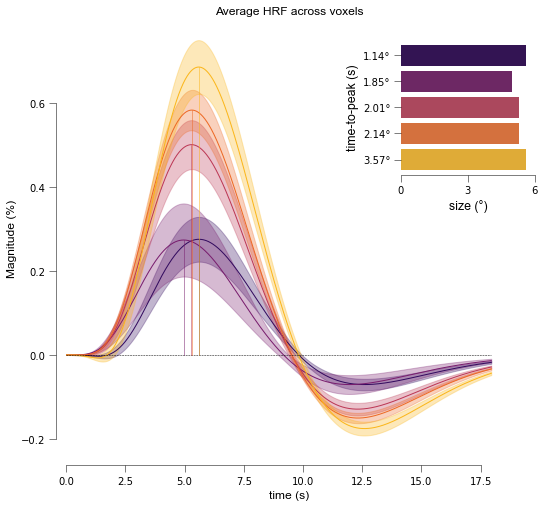

In [47]:
# we can fit with canonical HRFs
nd_gamma = fitting.NideconvFitter(df_ribbon,
                                  df_onsets,
                                  confounds=None,
                                  basis_sets='canonical_hrf_with_time_derivative',
                                  n_regressors=None,
                                  lump_events=False,
                                  TR=0.105,
                                  interval=[0, 18],
                                  add_intercept=True,
                                  verbose=True)

nd_gamma.plot_average_per_event(xkcd=False,
                                alpha=0.2,
                                figsize=(8, 8),
                                x_label="time (s)",
                                y_label="Magnitude (%)",
                                add_hline='default',
                                ttp=True,
                                ttp_lines=True,
                                add_labels=True,
                                y_label2="time-to-peak (s)",
                                x_label2="size (°)",
                                ttp_labels=[f"{round(float(ii),2)}°" for ii in nd_gamma.cond],
                                lim=[0, 6],
                                ticks=[0, 3, 6],
                                cmap='inferno',
                                save_as=opj(func_dir, "hrf_canonical.png"))


Here we consider the predictions that arise from the deconvolved HRF

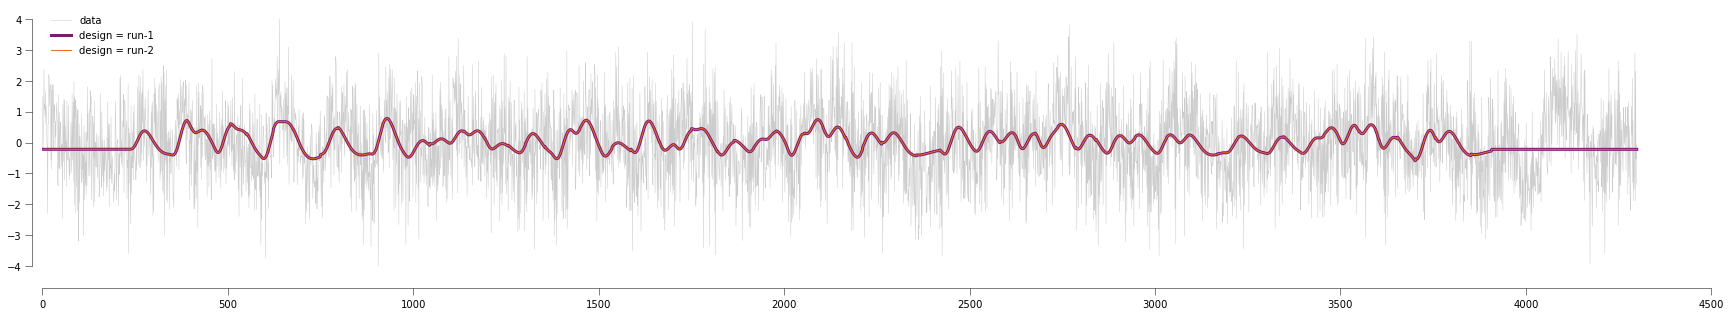

In [62]:
colors = sns.color_palette('inferno', 2)
cross_pred = nd_gamma.fitters.iloc[0].X.dot(nd_gamma.fitters.iloc[0].betas)

plotting.LazyPlot([utils.select_from_df(df_ribbon, expression="run = 3").iloc[:,0].values, 
                   utils.select_from_df(nd_gamma.predictions, expression="run = 3").iloc[:,0].values,
                   cross_pred.iloc[:,0].values], 
                   line_width=[0.5,3,1], 
                   color=["#cccccc"]+colors,
                   labels=["data", "design = run-1", "design = run-2"])

In [117]:
utils.select_from_df(df_onsets, expression=f"event_type = {nd_gamma.cond[0]}")


onset
subject run event_type                   
003     3   1.140879298089248  101.380051
            1.140879298089248  107.305134
            1.140879298089248  124.246617
            1.140879298089248  156.696457
            1.140879298089248  173.188099
            1.140879298089248  189.746253
            1.140879298089248  197.829608
            1.140879298089248  333.486816
            1.140879298089248  344.870505
            1.140879298089248  354.812066
        4   1.140879298089248  101.788788
            1.140879298089248  195.846581
            1.140879298089248  235.537773
            1.140879298089248  258.412958
            1.140879298089248  298.062798
            1.140879298089248  314.270983
            1.140879298089248  322.879359
            1.140879298089248  346.070881
            1.140879298089248  380.187420
            1.140879298089248  385.670735
        6   1.140879298089248   60.571387
            1.140879298089248   67.804659
            1.140879298089248   73.796298
            1.140879298089248  121.546042
            1.140879298089248  132.879328
            1.140879298089248  258.287054
            1.140879298089248  330.520105
            1.140879298089248  365.736563
            1.140879298089248  373.028252
            1.140879298089248  382.953138

In [120]:
# individual model fits
fit_objs = []
for ii in nd_gamma.cond:

    nd_fit = fitting.NideconvFitter(df_ribbon,
                                    utils.select_from_df(df_onsets, expression=f"event_type = {ii}"),
                                    confounds=None,
                                    basis_sets='canonical_hrf_with_time_derivative',
                                    n_regressors=None,
                                    lump_events=False,
                                    TR=0.105,
                                    interval=[0, 18],
                                    add_intercept=True,
                                    verbose=True)

    nd_fit.timecourses_condition()
    fit_objs.append(nd_fit)

Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '1.140879298089248' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '1.853928859395028' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '2.014613132977678' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '2.13914868391734' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '3.5652478065289' to model
Fitting with 'ols' minimization
Done


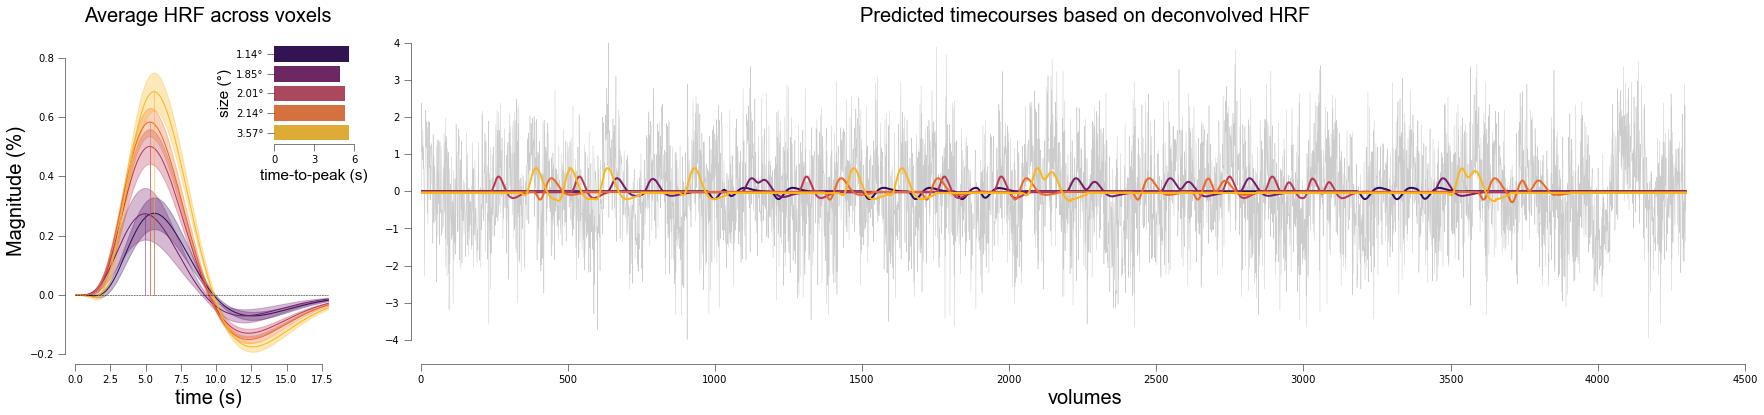

In [140]:
fig = plt.figure(figsize=(30,6))
gs = fig.add_gridspec(1,2, width_ratios=[1,5], wspace=0.1)
font_size = 20

ax1 = fig.add_subplot(gs[0])
nd_gamma.plot_average_per_event(xkcd=False,
                                alpha=0.2,
                                axs=ax1,
                                x_label="time (s)",
                                y_label="Magnitude (%)",
                                add_hline='default',
                                ttp=True,
                                ttp_lines=True,
                                add_labels=True,
                                y_label2="size (°)",
                                x_label2="time-to-peak (s)",
                                ttp_labels=[f"{round(float(ii),2)}°" for ii in nd_gamma.cond],
                                lim=[0, 6],
                                ticks=[0, 3, 6],
                                cmap='inferno',
                                y_lim=[-0.2,0.9],
                                font_size=font_size)

ax2 = fig.add_subplot(gs[1])
colors = sns.color_palette('inferno', len(nd_gamma.cond))
preds = [utils.select_from_df(fit_objs[ii].predictions, expression="run = 3").iloc[:,0].values for ii in range(len(fit_objs))]
plotting.LazyPlot([utils.select_from_df(df_ribbon, expression="run = 3").iloc[:,0].values]+preds,
                  line_width=[0.5]+[2 for ii in range(len(fit_objs))], 
                  color=["#cccccc"]+colors,
                  axs=ax2,
                  title="Predicted timecourses based on deconvolved HRF",
                  font_size=font_size,
                  x_label="volumes")
                #    labels=["data"]+[f"fit ev{ii+1}" for ii in range(len(fit_objs))])


In [141]:
nd_gamma.tc_conditio

vox 356       vox 357  \
event_type        covariate time                                    
1.140879298089248 intercept 0.000000  -1.883275e-08 -1.663156e-08   
                            0.005252  -2.545367e-08 -2.247861e-08   
                            0.010503  -3.389153e-08 -2.993025e-08   
                            0.015755  -4.451814e-08 -3.931480e-08   
                            0.021006  -5.775690e-08 -5.100616e-08   
...                                             ...           ...   
3.5652478065289   intercept 17.928742 -5.390154e-02 -5.471700e-02   
                            17.933994 -5.378062e-02 -5.459475e-02   
                            17.939245 -5.365992e-02 -5.447272e-02   
                            17.944497 -5.353942e-02 -5.435089e-02   
                            17.949748 -5.341913e-02 -5.422928e-02   

                                            vox 358       vox 359  \
event_type        covariate time                                    
1.140879298089248 intercept 0.000000  -4.062842e-08 -1.171575e-08   
                            0.005252  -5.491189e-08 -1.583458e-08   
                            0.010503  -7.311514e-08 -2.108373e-08   
                            0.015755  -9.604036e-08 -2.769447e-08   
                            0.021006  -1.246015e-07 -3.593016e-08   
...                                             ...           ...   
3.5652478065289   intercept 17.928742 -5.106745e-02 -4.790232e-02   
                            17.933994 -5.095562e-02 -4.779833e-02   
                            17.939245 -5.084397e-02 -4.769452e-02   
                            17.944497 -5.073250e-02 -4.759087e-02   
                            17.949748 -5.062122e-02 -4.748739e-02   

                                            vox 360       vox 361  \
event_type        covariate time                                    
1.140879298089248 intercept 0.000000  -3.378665e-08 -8.132482e-09   
                            0.005252  -4.566481e-08 -1.099157e-08   
                            0.010503  -6.080267e-08 -1.463526e-08   
                            0.015755  -7.986734e-08 -1.922413e-08   
                            0.021006  -1.036189e-07 -2.494108e-08   
...                                             ...           ...   
3.5652478065289   intercept 17.928742 -3.953584e-02 -3.721499e-02   
                            17.933994 -3.945123e-02 -3.713288e-02   
                            17.939245 -3.936674e-02 -3.705091e-02   
                            17.944497 -3.928239e-02 -3.696908e-02   
                            17.949748 -3.919817e-02 -3.688739e-02   

                                            vox 362  
event_type        covariate time                     
1.140879298089248 intercept 0.000000   1.604457e-08  
                            0.005252   2.168526e-08  
                            0.010503   2.887392e-08  
                            0.015755   3.792738e-08  
                            0.021006   4.920674e-08  
...                                             ...  
3.5652478065289   intercept 17.928742 -2.371001e-02  
                            17.933994 -2.365428e-02  
                            17.939245 -2.359866e-02  
                            17.944497 -2.354314e-02  
                            17.949748 -2.348772e-02  

[17095 rows x 7 columns]

In [65]:
nd_gamma.fitters.iloc[0].predict_from_design_matrix()

,prediction for vox 356,prediction for vox 357,prediction for vox 358,prediction for vox 359,prediction for vox 360,prediction for vox 361,prediction for vox 362
time,,,,,,,
0.000,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
0.105,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
0.210,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
0.315,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
0.420,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
...,...,...,...,...,...,...,...
450.975,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
451.080,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
451.185,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665


In [59]:
cross_pred.iloc[:,0].values

array([-0.21889215, -0.21889215, -0.21889215, ..., -0.21889215,
       -0.21889215, -0.21889215])

In [53]:
cross_pred = nd_gamma.fitters.iloc[0].predict_from_design_matrix(X=nd_gamma.fitters.iloc[1].X)
cross_pred

,prediction for vox 356,prediction for vox 357,prediction for vox 358,prediction for vox 359,prediction for vox 360,prediction for vox 361,prediction for vox 362
time,,,,,,,
0.000,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
0.105,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
0.210,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
0.315,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
0.420,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
...,...,...,...,...,...,...,...
450.975,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
451.080,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665
451.185,-0.218892,-0.291832,-0.196883,-0.145555,-0.048666,-0.070279,-0.075665


In [69]:
# we can fit with fourier
nd_fourier = utils.NideconvFitter(df_ribbon,
                                  df_onsets,
                                  confounds=None,
                                  basis_sets='fourier',
                                  n_regressors=4,
                                  lump_events=False,
                                  TR=0.105,
                                  interval=[0,18],
                                  add_intercept=False,
                                  verbose=True)

Selected 'fourier'-basis sets
Adding event '1.140879298089248' to model
Adding event '1.853928859395028' to model
Adding event '2.014613132977678' to model
Adding event '2.13914868391734' to model
Adding event '3.5652478065289' to model
Fitting with 'ols' minimization
Done


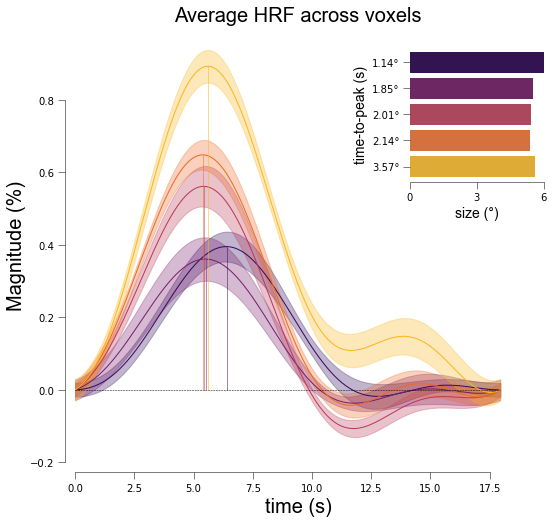

In [70]:
nd_fourier.plot_average_per_event(xkcd=False,
                                  figsize=(8, 8),
                                  x_label="time (s)",
                                  y_label="Magnitude (%)",
                                  add_hline='default',
                                  y_lim=[-0.2,1],
                                  ttp=True,
                                  ttp_lines=True,
                                  add_labels=True,
                                  y_label2="time-to-peak (s)",
                                  x_label2="size (°)",
                                  ttp_labels=[f"{round(float(ii),2)}°" for ii in nd_fourier.cond],
                                  lim=[0, 6],
                                  ticks=[0, 3, 6],
                                  cmap='inferno',
                                  save_as=opj(func_dir, "hrf_fourier.png"))


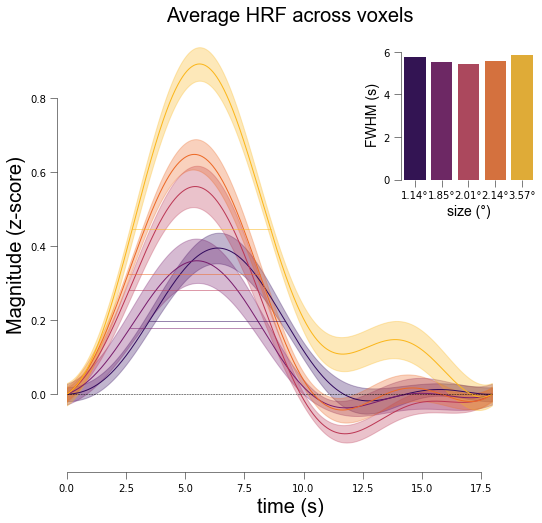

In [72]:
nd_fourier.plot_average_per_event(xkcd=False,
                                  alpha=0.2,
                                  x_label="time (s)",
                                  y_label="Magnitude (z-score)",
                                  add_hline='default',
                                  sns_trim=True,
                                  fwhm=True,
                                  fwhm_lines=True,
                                #   lim=[0,5],
                                #   ticks=[i for i in range(6)],
                                  fwhm_labels=[f"{round(float(ii),2)}°" for ii in nd_fourier.cond],
                                  add_labels=True,
                                  x_label2="size (°)",
                                  y_label2="FWHM (s)",
                                  cmap='inferno')


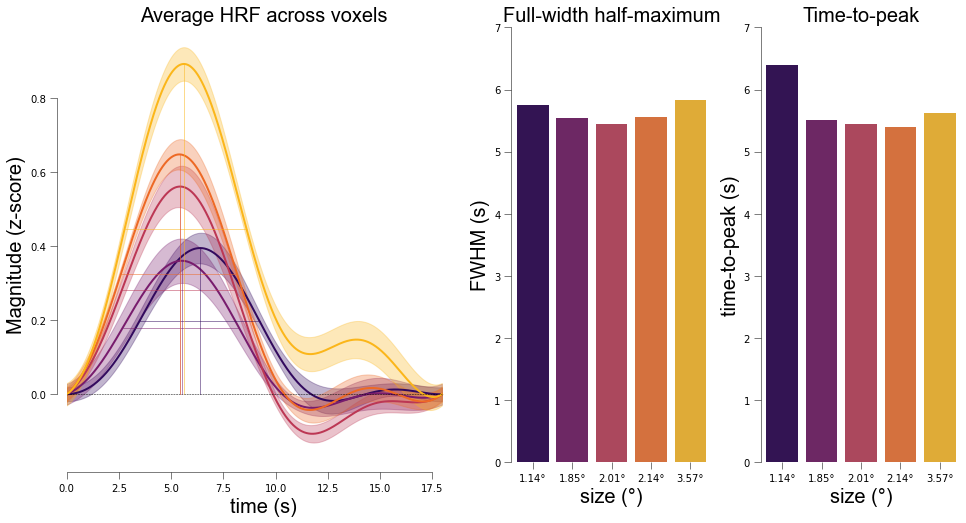

In [76]:
fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(1,3, width_ratios=[2,1,1])

ax = fig.add_subplot(gs[0])
nd_fourier.plot_average_per_event(axs=ax,
                                  alpha=0.2,
                                  x_label="time (s)",
                                  y_label="Magnitude (z-score)",
                                  add_hline='default',
                                  line_width=2,
                                  cmap='inferno')

ax2 = fig.add_subplot(gs[1])
nd_fourier.plot_fwhm(nd_fourier.event_avg, 
                     axs=ax2, 
                     hrf_axs=ax, 
                     fwhm_labels=[f"{round(float(ii),2)}°" for ii in nd_fourier.cond],
                     x_label2="size (°)",
                     y_label2="FWHM (s)",
                     title2="Full-width half-maximum",
                     add_labels=True,
                     font_size=20,
                     lim=[0, 7],
                     fwhm_lines=True)

ax3 = fig.add_subplot(gs[2])
nd_fourier.plot_ttp(nd_fourier.event_avg, 
                    axs=ax3,
                    hrf_axs=ax, 
                    ttp_labels=[f"{round(float(ii),2)}°" for ii in nd_fourier.cond],
                    y_label2="time-to-peak (s)",
                    x_label2="size (°)",
                    title2="Time-to-peak",
                    add_labels=True,
                    font_size=20,
                    lim=[0,7],
                    ttp_lines=True,
                    ttp_ori='v')


The models above considered each stimulus event (stimulus size) as separate event. Again, we can also lump them together into a single event to get an `average HRF`

Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event 'stim' to model
Fitting with 'ols' minimization
Done


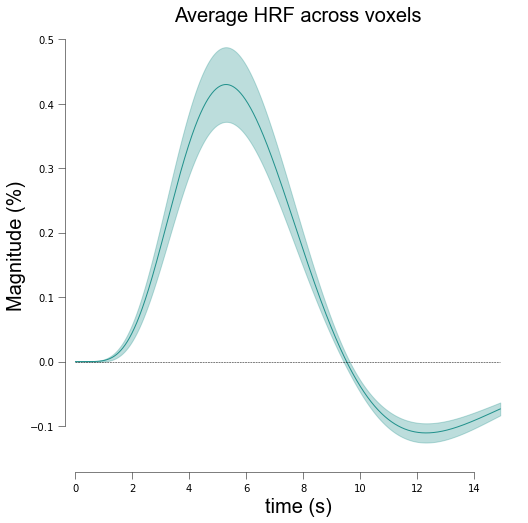

In [78]:
lumped = utils.NideconvFitter(df_ribbon,
                              df_onsets,
                              confounds=None,
                              basis_sets='canonical_hrf_with_time_derivative',
                              n_regressors=4,
                              lump_events=True,
                              TR=0.105,
                              interval=[0, 15],
                              add_intercept=True,
                              verbose=True,
                              fit_type='ols')

lumped.plot_average_per_event(figsize=(8, 8),
                              x_label="time (s)",
                              y_label="Magnitude (%)",
                              add_hline='default',
                              sns_trim=True,
                              save_as=opj(func_dir, "hrf_average.png"))


Then, we can also average across events, but not across depth. This should give use an HRF for each voxel along the cortical ribbon.

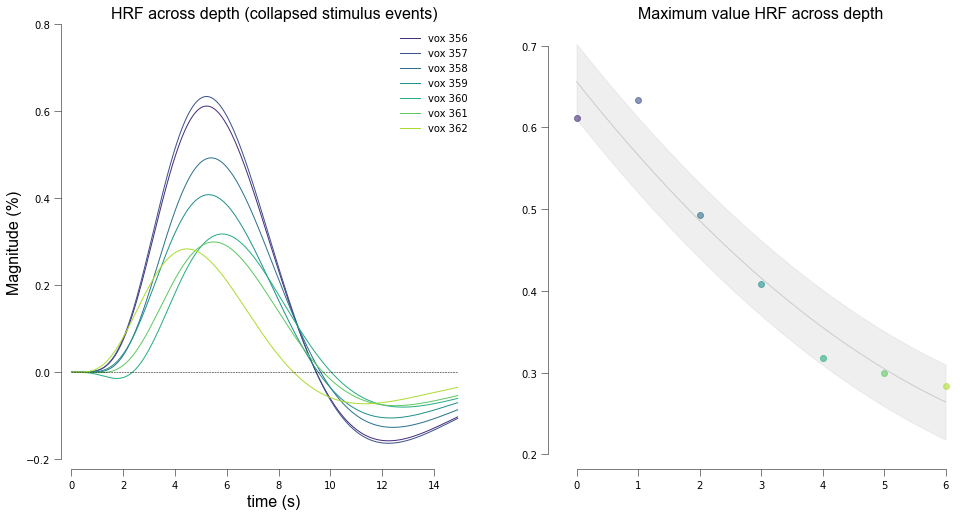

In [81]:
# plot individual voxels in 1 figure
fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(1,2)

ax = fig.add_subplot(gs[0])
lumped.plot_average_per_voxel(n_cols=None,
                              figsize=(8, 8),
                              axs=ax,
                              labels=True,
                              title="HRF across depth (collapsed stimulus events)",
                              x_label="time (s)",
                              y_label="Magnitude (%)",
                              y_lim=[-.2,0.8])

ax = fig.add_subplot(gs[1])
lumped.plot_hrf_across_depth(axs=ax,
                             title="Maximum value HRF across depth",
                             set_xlim_zero=False,
                             order=2)

img = opj(func_dir, f"hrf_across_depth.png")
fig.savefig(img)
